# Single-shot denoising for simulated data

Use dncnn with kernelpredicting to denoise simulated data.
We demonstrate that a deep neural net can be trained to denoise a single noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [5]:
from skimage.io import imread, imsave
plt.rc('figure', figsize = (5,5))

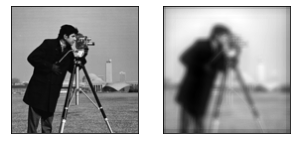

In [6]:
from skimage import transform
from skimage import data, img_as_float, img_as_ubyte
image = imread('../figs/origin_camera.png')#numpy
image = img_as_float(image)
noisy_image = imread('../figs/blurred_camera.png')#numpy
noisy_image = img_as_float(noisy_image)
plt.subplot(1,2,1)
show(image)
plt.subplot(1,2,2)
show(noisy_image)

In [ ]:
#read and save image
#astro = img_as_float(data.astronaut())
#show(astro[:,:,1])
#imsave('../figs/astro.png', img_as_ubyte(astro[:,:,1]))

In [7]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])
clean = torch.Tensor(image[np.newaxis, np.newaxis])#input & output cant use same name
print(noisy.shape)

torch.Size([1, 1, 128, 128])


In [ ]:
#plot_tensors([noisy, clean])

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [8]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a dncnn with kernelpredicting.

In [9]:
from models.babyunet import BabyUnet
from models.unet import Unet
from models.dncnn import DnCNN, DnCNNKernel, ResCNN

from models.kernelpredicting import KernelPredicting

model = DnCNNKernel(1, num_of_layers = 8)
# model = ResCNN(1, 32, 8)
#model = KernelPredicting(1, DnCNN, kernel_width=15,
#                         depth= 6,
#                          features= 32)
#model = Unet(activation='relu')

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

17760

In [ ]:
#image.ravel().shape

# Training

In [11]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

In [ ]:
noisy.shape

In [ ]:
#self-supervised
losses = []
val_losses = []
best_images = []
best_val_loss = 1


for i in range(100):
    model.train()
    
    net_input, mask = masker.mask(noisy, i%(masker.n_masks-1))
    net_output = model(net_input)
    #print(net_output.shape)
    #print(noisy.shape)
    
    loss = loss_function(net_output*mask, noisy*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    losses.append(loss.item())
    
    if i % 5 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            #print(denoised.shape)
            #print(image.shape)
            best_psnr = compare_psnr(denoised, image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

In [12]:
#supervised
losses = []
val_losses = []
best_images = []
best_val_loss = loss_function(noisy, 0*noisy)

net_input = noisy

for i in range(3000):
    model.train()
    
    net_output = model(net_input)
    #print(net_output.shape)
    #print(noisy.shape)
    #print(clean.shape)
    
    loss = loss_function(net_output, clean)
    #print(net_input)
    #print(net_output)
    #print(clean)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    losses.append(loss.item())
    
    if i % 5 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))
        
        model.eval()
    
        val_loss = loss_function(net_output, clean)
        
        print("PSNR (", i, "): \t", round(-10*np.log10(val_loss.item()), 2))
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_images.append(np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64))
#           best_psnr = compare_psnr(np.clip(best_images[-1][0,0].numpy(), 0, 1), img_as_float(image))
#           print("Best PSNR: ", np.round(best_psnr, 2))

Loss ( 0 ): 	 0.0139
PSNR ( 0 ): 	 18.57
Loss ( 5 ): 	 0.0134
PSNR ( 5 ): 	 18.72
Loss ( 10 ): 	 0.0132
PSNR ( 10 ): 	 18.81
Loss ( 15 ): 	 0.0129
PSNR ( 15 ): 	 18.89
Loss ( 20 ): 	 0.0126
PSNR ( 20 ): 	 18.98
Loss ( 25 ): 	 0.0124
PSNR ( 25 ): 	 19.06
Loss ( 30 ): 	 0.0122
PSNR ( 30 ): 	 19.14
Loss ( 35 ): 	 0.012
PSNR ( 35 ): 	 19.2
Loss ( 40 ): 	 0.0119
PSNR ( 40 ): 	 19.26
Loss ( 45 ): 	 0.0117
PSNR ( 45 ): 	 19.32
Loss ( 50 ): 	 0.0116
PSNR ( 50 ): 	 19.37
Loss ( 55 ): 	 0.0114
PSNR ( 55 ): 	 19.42
Loss ( 60 ): 	 0.0113
PSNR ( 60 ): 	 19.47
Loss ( 65 ): 	 0.0112
PSNR ( 65 ): 	 19.51
Loss ( 70 ): 	 0.0111
PSNR ( 70 ): 	 19.55
Loss ( 75 ): 	 0.011
PSNR ( 75 ): 	 19.59
Loss ( 80 ): 	 0.0109
PSNR ( 80 ): 	 19.62
Loss ( 85 ): 	 0.0108
PSNR ( 85 ): 	 19.66
Loss ( 90 ): 	 0.0107
PSNR ( 90 ): 	 19.69
Loss ( 95 ): 	 0.0106
PSNR ( 95 ): 	 19.73
Loss ( 100 ): 	 0.0105
PSNR ( 100 ): 	 19.77
Loss ( 105 ): 	 0.0104
PSNR ( 105 ): 	 19.81
Loss ( 110 ): 	 0.0103
PSNR ( 110 ): 	 19.86
Loss ( 115 )

Loss ( 920 ): 	 0.0062
PSNR ( 920 ): 	 22.1
Loss ( 925 ): 	 0.0062
PSNR ( 925 ): 	 22.1
Loss ( 930 ): 	 0.0062
PSNR ( 930 ): 	 22.11
Loss ( 935 ): 	 0.0062
PSNR ( 935 ): 	 22.11
Loss ( 940 ): 	 0.0061
PSNR ( 940 ): 	 22.11
Loss ( 945 ): 	 0.0061
PSNR ( 945 ): 	 22.12
Loss ( 950 ): 	 0.0061
PSNR ( 950 ): 	 22.12
Loss ( 955 ): 	 0.0061
PSNR ( 955 ): 	 22.12
Loss ( 960 ): 	 0.0061
PSNR ( 960 ): 	 22.12
Loss ( 965 ): 	 0.0061
PSNR ( 965 ): 	 22.13
Loss ( 970 ): 	 0.0061
PSNR ( 970 ): 	 22.13
Loss ( 975 ): 	 0.0061
PSNR ( 975 ): 	 22.13
Loss ( 980 ): 	 0.0061
PSNR ( 980 ): 	 22.13
Loss ( 985 ): 	 0.0061
PSNR ( 985 ): 	 22.14
Loss ( 990 ): 	 0.0061
PSNR ( 990 ): 	 22.14
Loss ( 995 ): 	 0.0061
PSNR ( 995 ): 	 22.14
Loss ( 1000 ): 	 0.0061
PSNR ( 1000 ): 	 22.14
Loss ( 1005 ): 	 0.0061
PSNR ( 1005 ): 	 22.15
Loss ( 1010 ): 	 0.0061
PSNR ( 1010 ): 	 22.15
Loss ( 1015 ): 	 0.0061
PSNR ( 1015 ): 	 22.15
Loss ( 1020 ): 	 0.0061
PSNR ( 1020 ): 	 22.15
Loss ( 1025 ): 	 0.0061
PSNR ( 1025 ): 	 22.16


Loss ( 1810 ): 	 0.0058
PSNR ( 1810 ): 	 22.34
Loss ( 1815 ): 	 0.0058
PSNR ( 1815 ): 	 22.34
Loss ( 1820 ): 	 0.0058
PSNR ( 1820 ): 	 22.34
Loss ( 1825 ): 	 0.0058
PSNR ( 1825 ): 	 22.35
Loss ( 1830 ): 	 0.0058
PSNR ( 1830 ): 	 22.35
Loss ( 1835 ): 	 0.0058
PSNR ( 1835 ): 	 22.35
Loss ( 1840 ): 	 0.0058
PSNR ( 1840 ): 	 22.35
Loss ( 1845 ): 	 0.0058
PSNR ( 1845 ): 	 22.35
Loss ( 1850 ): 	 0.0058
PSNR ( 1850 ): 	 22.35
Loss ( 1855 ): 	 0.0058
PSNR ( 1855 ): 	 22.35
Loss ( 1860 ): 	 0.0058
PSNR ( 1860 ): 	 22.35
Loss ( 1865 ): 	 0.0058
PSNR ( 1865 ): 	 22.35
Loss ( 1870 ): 	 0.0058
PSNR ( 1870 ): 	 22.35
Loss ( 1875 ): 	 0.0058
PSNR ( 1875 ): 	 22.35
Loss ( 1880 ): 	 0.0058
PSNR ( 1880 ): 	 22.35
Loss ( 1885 ): 	 0.0058
PSNR ( 1885 ): 	 22.35
Loss ( 1890 ): 	 0.0058
PSNR ( 1890 ): 	 22.35
Loss ( 1895 ): 	 0.0058
PSNR ( 1895 ): 	 22.35
Loss ( 1900 ): 	 0.0058
PSNR ( 1900 ): 	 22.35
Loss ( 1905 ): 	 0.0058
PSNR ( 1905 ): 	 22.35
Loss ( 1910 ): 	 0.0058
PSNR ( 1910 ): 	 22.35
Loss ( 1915 )

Loss ( 2685 ): 	 0.0057
PSNR ( 2685 ): 	 22.42
Loss ( 2690 ): 	 0.0057
PSNR ( 2690 ): 	 22.42
Loss ( 2695 ): 	 0.0057
PSNR ( 2695 ): 	 22.42
Loss ( 2700 ): 	 0.0057
PSNR ( 2700 ): 	 22.42
Loss ( 2705 ): 	 0.0057
PSNR ( 2705 ): 	 22.42
Loss ( 2710 ): 	 0.0057
PSNR ( 2710 ): 	 22.42
Loss ( 2715 ): 	 0.0057
PSNR ( 2715 ): 	 22.42
Loss ( 2720 ): 	 0.0057
PSNR ( 2720 ): 	 22.42
Loss ( 2725 ): 	 0.0057
PSNR ( 2725 ): 	 22.42
Loss ( 2730 ): 	 0.0057
PSNR ( 2730 ): 	 22.42
Loss ( 2735 ): 	 0.0057
PSNR ( 2735 ): 	 22.42
Loss ( 2740 ): 	 0.0057
PSNR ( 2740 ): 	 22.42
Loss ( 2745 ): 	 0.0057
PSNR ( 2745 ): 	 22.42
Loss ( 2750 ): 	 0.0057
PSNR ( 2750 ): 	 22.42
Loss ( 2755 ): 	 0.0057
PSNR ( 2755 ): 	 22.42
Loss ( 2760 ): 	 0.0057
PSNR ( 2760 ): 	 22.42
Loss ( 2765 ): 	 0.0057
PSNR ( 2765 ): 	 22.42
Loss ( 2770 ): 	 0.0057
PSNR ( 2770 ): 	 22.42
Loss ( 2775 ): 	 0.0057
PSNR ( 2775 ): 	 22.42
Loss ( 2780 ): 	 0.0057
PSNR ( 2780 ): 	 22.42
Loss ( 2785 ): 	 0.0057
PSNR ( 2785 ): 	 22.42
Loss ( 2790 )

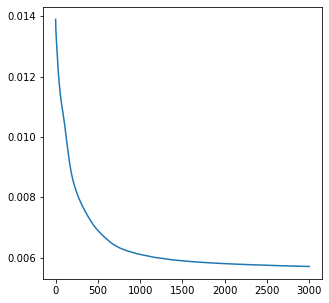

In [13]:
plt.plot(losses)

In [ ]:
plot_images(best_images[::2])

In [14]:
denoised = best_images[-1]

In [15]:
#compare_psnr(denoised, image)
print(denoised.shape)
compare_psnr(denoised, image)

(128, 128)


/home/disk/disk1/LiuTQ/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


22.43491568966189

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


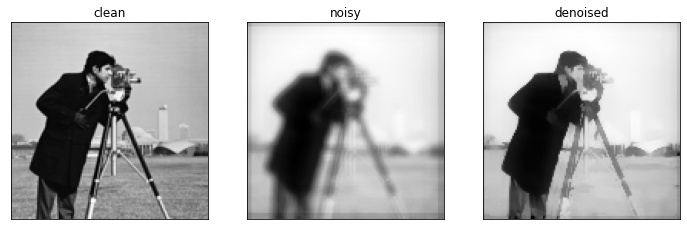

In [16]:
image_ = torch.Tensor(image[np.newaxis, np.newaxis])
denoised_ = torch.Tensor(denoised[np.newaxis, np.newaxis])
print(image_.shape)
print(denoised_.shape)
print(noisy.shape)
plot_tensors([image_, noisy, denoised_],["clean", "noisy", "denoised"])

Loss : 	 0.0181
PSNR : 	 17.42
torch.Size([1, 1, 128, 128]) torch.Size([1, 1, 128, 128]) torch.Size([1, 1, 128, 128])


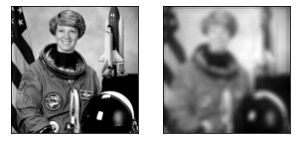

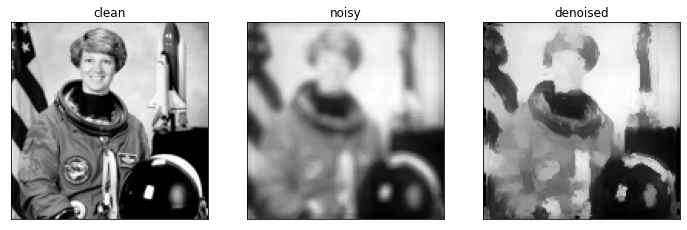

In [17]:
# use model trained from one image pair to process another imag
origin_astro = imread('../figs/origin_astro.png')#numpy
origin_astro = img_as_float(origin_astro)
blurred_astro = imread('../figs/blurred_astro.png')#numpy
blurred_astro = img_as_float(blurred_astro)
plt.subplot(1,2,1)
show(origin_astro)
plt.subplot(1,2,2)
show(blurred_astro)

noisy_astro = torch.Tensor(blurred_astro[np.newaxis, np.newaxis])
clean_astro = torch.Tensor(origin_astro[np.newaxis, np.newaxis])#input & output cant use same name

model.eval()
net_output = model(noisy_astro)
val_loss = loss_function(net_output, clean_astro)
print("Loss : \t", round(val_loss.item(), 4))
print("PSNR : \t", round(-10*np.log10(val_loss.item()), 2))

print(clean_astro.shape, noisy_astro.shape, net_output.shape)
plot_tensors([clean_astro, noisy_astro, net_output.detach().cpu()],["clean", "noisy", "denoised"])